In [ ]:
drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np

input_path = r"/content/drive/MyDrive/project/project/extract_frames"
output_path = r"/content/drive/MyDrive/project/project/preproc"

os.makedirs(output_path, exist_ok=True)


IMG_SIZE = (224, 224)

def preprocess_image(image_path, output_folder):

    img = cv2.imread(image_path)

    if img is None:
        print(f"Error reading {image_path}")
        return False


    img = cv2.resize(img, IMG_SIZE)


    img = img / 255.0


    output_file = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_file, img * 255)

    return True


for root, _, files in os.walk(input_path):
    for file in files:
        if file.endswith(".jpg"):
            image_path = os.path.join(root, file)


            relative_path = os.path.relpath(root, input_path)
            output_folder = os.path.join(output_path, relative_path)
            os.makedirs(output_folder, exist_ok=True)

            success = preprocess_image(image_path, output_folder)
            if success:
                print(f"Preprocessed: {file}")

print("✅ Preprocessing Completed!")


✅ Preprocessing Completed!


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Paths to CSV label files
train_csv = "/content/drive/MyDrive/project/Labels/TrainLabels.csv"
val_csv = "/content/drive/MyDrive/project/Labels/ValidationLabels.csv"
test_csv = "/content/drive/MyDrive/project/Labels/TestLabels.csv"

# Paths to preprocessed images
train_img_path = "/content/drive/MyDrive/project/preproc/Train"
val_img_path = "/content/drive/MyDrive/project/preproc/Validation"
test_img_path = "/content/drive/MyDrive/project/preproc/Test"

# Folder to store processed dataset
output_folder = "/content/drive/MyDrive/project/project/dataset"
os.makedirs(output_folder, exist_ok=True)

# Load label CSV files
train_labels = pd.read_csv(train_csv)
val_labels = pd.read_csv(val_csv)
test_labels = pd.read_csv(test_csv)

# Function to generate folder path based on ClipID
def folder_path(clip_id, main_path):
    main_fold = clip_id[:6]
    sub_fold = clip_id.split('.')[0]
    return os.path.join(main_path, main_fold, sub_fold)

# Add FolderPath column to each dataset
train_labels['FolderPath'] = train_labels['ClipID'].apply(lambda x: folder_path(x, train_img_path))
val_labels['FolderPath'] = val_labels['ClipID'].apply(lambda x: folder_path(x, val_img_path))
test_labels['FolderPath'] = test_labels['ClipID'].apply(lambda x: folder_path(x, test_img_path))

# Function to load reduced number of images & labels
def load_images_and_labels(df, num_frames=5, img_size=(128, 128)):
    images = []
    labels = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        folder_path = row['FolderPath']
        label = row['Engagement']

        if os.path.exists(folder_path):
            img_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
            sampled_files = img_files[::max(1, len(img_files)//num_frames)][:num_frames]

            for img_file in sampled_files:
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    img = img.astype(np.float32) / 255.0
                    images.append(img)
                    labels.append(label)

    return np.array(images, dtype=np.float32), np.array(labels)

# Load and save images and labels for Train, Validation, and Testokok
X_train, y_train = load_images_and_labels(train_labels)
np.save(os.path.join(output_folder, 'X_train.npy'), X_train)
np.save(os.path.join(output_folder, 'y_train.npy'), y_train)

X_val, y_val = load_images_and_labels(val_labels)
np.save(os.path.join(output_folder, 'X_val.npy'), X_val)
np.save(os.path.join(output_folder, 'y_val.npy'), y_val)

X_test, y_test = load_images_and_labels(test_labels)
np.save(os.path.join(output_folder, 'X_test.npy'), X_test)
np.save(os.path.join(output_folder, 'y_test.npy'), y_test)


100%|██████████| 1784/1784 [34:19<00:00,  1.15s/it]


In [ ]:
# prompt: generate a code for dimensionality reduction using svd with output

import numpy as np
from sklearn.decomposition import TruncatedSVD
import os # Import the os module here

# Define output_folder (Make sure it matches the path from previous cells)
output_folder = "/content/drive/project/MyDrive/project/project/dataset" # Add this line to define the variable


# Load the saved NumPy arrays
X_train = np.load(os.path.join(output_folder, 'X_train.npy'))
X_val = np.load(os.path.join(output_folder, 'X_val.npy'))
X_test = np.load(os.path.join(output_folder, 'X_test.npy'))

# Reshape the data to 2D for SVD
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Define the number of components to keep
n_components = 100  # Example: Reduce to 100 components

# Initialize and fit SVD on the training data
svd = TruncatedSVD(n_components=n_components)
X_train_reduced = svd.fit_transform(X_train_reshaped)

# Transform validation and test data using the fitted SVD
X_val_reduced = svd.transform(X_val_reshaped)
X_test_reduced = svd.transform(X_test_reshaped)

# Print shapes of reduced data
print("Shape of reduced training data:", X_train_reduced.shape)
print("Shape of reduced validation data:", X_val_reduced.shape)
print("Shape of reduced test data:", X_test_reduced.shape)

# Now you can use X_train_reduced, X_val_reduced, and X_test_reduced for further processing
# For example, save the reduced data as new numpy arrays:
np.save(os.path.join(output_folder, 'X_train_reduced.npy'), X_train_reduced)
np.save(os.path.join(output_folder, 'X_val_reduced.npy'), X_val_reduced)
np.save(os.path.join(output_folder, 'X_test_reduced.npy'), X_test_reduced)

Shape of reduced training data: (10862, 100)
Shape of reduced validation data: (4287, 100)
Shape of reduced test data: (5352, 100)


In [ ]:
from tensorflow.keras.utils import to_categorical
import os
import numpy as np

# ... (Your existing code to define output_folder) ...

# ✅ Load y_train, y_val, y_test before using them:
output_folder = "/content/drive/project/MyDrive/project/project/dataset"
y_train = np.load(os.path.join(output_folder, "y_train.npy"))
y_val = np.load(os.path.join(output_folder, "y_val.npy"))
y_test = np.load(os.path.join(output_folder, "y_test.npy"))

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Save preprocessed data as .npy files
# ... (Your existing code to save the data) ...

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.feature import hog
from tensorflow.keras.utils import to_categorical

# ✅ Step 1: Set Paths (Update These Based on Your Google Drive Location)
dataset_root = "/content/drive/project/MyDrive/project/project/preproc"

train_img_path = os.path.join(dataset_root, "Train")
val_img_path = os.path.join(dataset_root, "Validation")
test_img_path = os.path.join(dataset_root, "Test")

train_csv = "/content/drive/project/MyDrive/project/project/Labels/TrainLabels.csv"
val_csv = "/content/drive/project/MyDrive/project/project/Labels/ValidationLabels.csv"
test_csv = "/content/drive/project/MyDrive/project/project/Labels/TestLabels.csv"

output_folder = "/content/drive/project/MyDrive/project/project/hog_features"
os.makedirs(output_folder, exist_ok=True)

# ✅ Step 2: Load CSV Files
train_labels = pd.read_csv(train_csv)
val_labels = pd.read_csv(val_csv)
test_labels = pd.read_csv(test_csv)

# ✅ Step 3: Function to Generate Folder Path
def folder_path(clip_id, main_path):
    main_fold = clip_id[:6]  # Extract first 6 characters (e.g., '500039')
    sub_fold = clip_id.split('.')[0]  # Remove file extension (e.g., '5000392052')
    return os.path.join(main_path, main_fold, sub_fold)

# Apply function to each dataset
train_labels['FolderPath'] = train_labels['ClipID'].apply(lambda x: folder_path(x, train_img_path))
val_labels['FolderPath'] = val_labels['ClipID'].apply(lambda x: folder_path(x, val_img_path))
test_labels['FolderPath'] = test_labels['ClipID'].apply(lambda x: folder_path(x, test_img_path))

# ✅ Step 4: Function to Extract HOG Features
def extract_hog_features(df, img_size=(64, 64)):
    features = []
    labels = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting HOG Features"):
        folder_path = row['FolderPath']
        label = row['Engagement']  # Assuming 'Engagement' column exists

        if os.path.exists(folder_path):
            img_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
            for img_file in img_files:
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
                if img is not None:
                    img = cv2.resize(img, img_size)  # Resize to fixed size

                    # Compute HOG features
                    hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                                       orientations=9, block_norm='L2-Hys', visualize=False)

                    features.append(hog_features)
                    labels.append(label)

    return np.array(features), np.array(labels)

# ✅ Step 5: Extract HOG Features from Train, Validation, and Test sets
X_train, y_train = extract_hog_features(train_labels)
X_val, y_val = extract_hog_features(val_labels)
X_test, y_test = extract_hog_features(test_labels)

# ✅ Step 6: Convert Labels to One-Hot Encoding
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# ✅ Step 7: Save HOG Features as .npy Files
np.save(os.path.join(output_folder, "X_train.npy"), X_train)
np.save(os.path.join(output_folder, "y_train.npy"), y_train)
np.save(os.path.join(output_folder, "X_val.npy"), X_val)
np.save(os.path.join(output_folder, "y_val.npy"), y_val)
np.save(os.path.join(output_folder, "X_test.npy"), X_test)
np.save(os.path.join(output_folder, "y_test.npy"), y_test)

print(f"✅ HOG Feature Extraction Completed! Features saved in {output_folder}")
print(f"Feature Shape: Training {X_train.shape}, Validation {X_val.shape}, Testing {X_test.shape}")


Extracting HOG Features: 100%|██████████| 1784/1784 [00:50<00:00, 35.26it/s]


✅ HOG Feature Extraction Completed! Features saved in /content/drive/project/MyDrive/project/project/hog_features
Feature Shape: Training (10864, 1764), Validation (4287, 1764), Testing (5352, 1764)


In [ ]:
#1D CNN
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os

# Load the preprocessed data
output_folder = "/content/drive/MyDrive/project/project/hog_features"
X_train = np.load(os.path.join(output_folder, "X_train.npy"))
y_train = np.load(os.path.join(output_folder, "y_train.npy"))
X_val = np.load(os.path.join(output_folder, "X_val.npy"))
y_val = np.load(os.path.join(output_folder, "y_val.npy"))
X_test = np.load(os.path.join(output_folder, "X_test.npy"))
y_test = np.load(os.path.join(output_folder, "y_test.npy"))


# Reshape the input data for 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the 1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Assuming 4 output classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Train Accuracy: {accuracy*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 133s 385ms/step - accuracy: 0.5682 - loss: 0.8586 - val_accuracy: 0.5619 - val_loss: 1.0481
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 137s 371ms/step - accuracy: 0.6290 - loss: 0.7849 - val_accuracy: 0.5148 - val_loss: 1.0713
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 134s 347ms/step - accuracy: 0.6527 - loss: 0.7344 - val_accuracy: 0.5386 - val_loss: 1.1423
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 139s 338ms/step - accuracy: 0.6714 - loss: 0.6962 - val_accuracy: 0.5204 - val_loss: 1.1345
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 139s 328ms/step - accuracy: 0.7002 - loss: 0.6382 - val_accuracy: 0.5288 - val_loss: 1.2641
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 332ms/step - accuracy: 0.7405 - loss: 0.5574 - val_accuracy: 0.4745 - val_loss: 1.4198
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 140s 325ms/step - accuracy: 0.7788 - loss: 0.4832 - val_accuracy: 0.5129 - val_loss: 1.5425
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 115s 337ms/step - accuracy: 0.8218 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 95s 273ms/step - accuracy: 0.5731 - loss: 0.8646 - val_accuracy: 0.5134 - val_loss: 1.0957
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 136s 257ms/step - accuracy: 0.6308 - loss: 0.7748 - val_accuracy: 0.5017 - val_loss: 1.1439
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 141s 256ms/step - accuracy: 0.6580 - loss: 0.7287 - val_accuracy: 0.5036 - val_loss: 1.1203
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 146s 268ms/step - accuracy: 0.6636 - loss: 0.6949 - val_accuracy: 0.5542 - val_loss: 1.1029
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 138s 257ms/step - accuracy: 0.6919 - loss: 0.6482 - val_accuracy: 0.4826 - val_loss: 1.3449
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 260ms/step - accuracy: 0.7342 - loss: 0.5742 - val_accuracy: 0.5454 - val_loss: 1.3617
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 85s 249ms/step - accuracy: 0.7676 - loss: 0.5010 - val_accuracy: 0.5071 - val_loss: 1.5703
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 146s 260ms/step - accuracy: 0.8300 - l

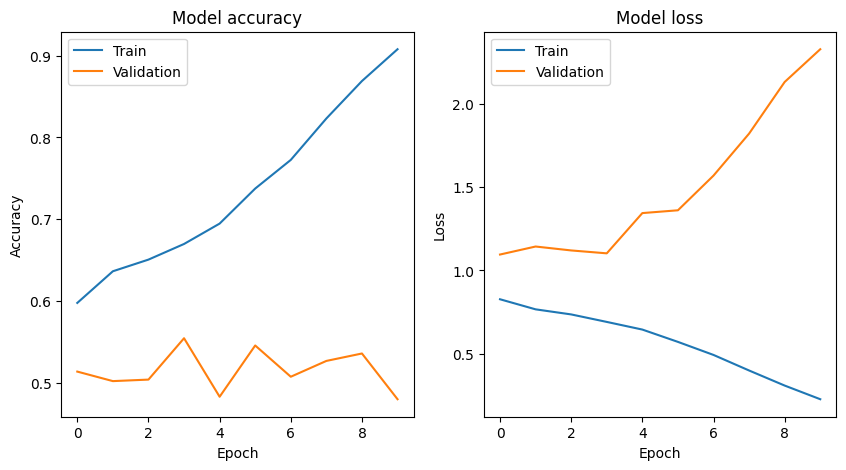

In [ ]:
# prompt: plot graph for above 1d cnn model with 92% training accuracy

import matplotlib.pyplot as plt
import numpy as np  # Assuming you're using NumPy for data loading
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import os # Make sure to import os

# Load the preprocessed data - Add this section to load the data
output_folder = "/content/drive/MyDrive/project/project/hog_features" # Define or update the output_folder path
X_train = np.load(os.path.join(output_folder, "X_train.npy"))
y_train = np.load(os.path.join(output_folder, "y_train.npy"))
X_val = np.load(os.path.join(output_folder, "X_val.npy"))
y_val = np.load(os.path.join(output_folder, "y_val.npy"))
#---


# Define and compile the model (same as before)
model = Sequential()
# ... (Add your model layers) ...
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Assuming 4 output classes
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model and store the history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Now you can plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# ... (Rest of your plotting code) ...
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.5371 - loss: 0.9124 - val_accuracy: 0.3149 - val_loss: 1.7462
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.5935 - loss: 0.8156 - val_accuracy: 0.3436 - val_loss: 1.0737
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.6270 - loss: 0.7799 - val_accuracy: 0.5689 - val_loss: 1.2940
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.6326 - loss: 0.7757 - val_accuracy: 0.5640 - val_loss: 1.4317
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 437s 1s/step - accuracy: 0.6398 - loss: 0.7494 - val_accuracy: 0.3254 - val_loss: 1.8121
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.6627 - loss: 0.7217 - val_accuracy: 0.5304 - val_loss: 1.1804
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.6759 - loss: 0.7038 - val_accuracy: 0.3984 - val_loss: 1.1966
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.6926 - loss: 0.6681 - val_accu

Test Accuracy: 50.41%


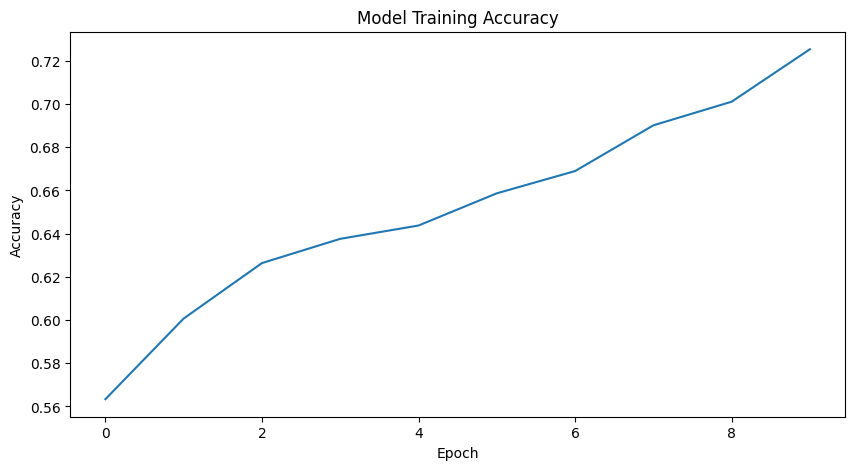

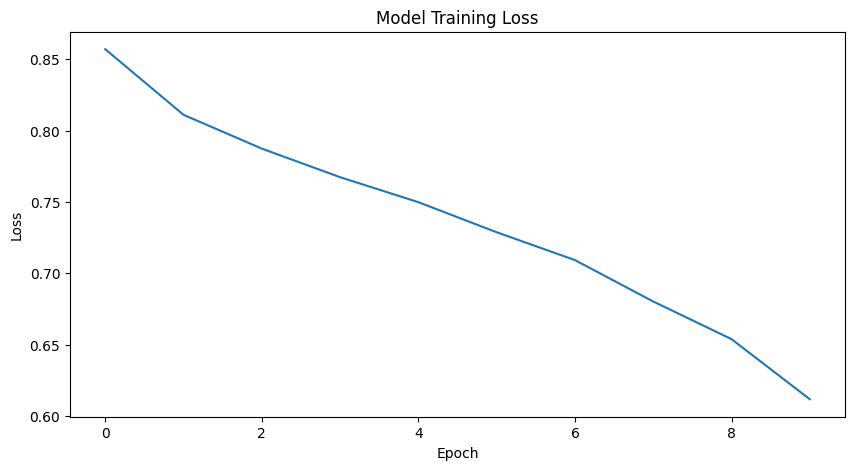

In [ ]:
+# prompt: plot training accuracy and training loss seperately for above 1d resnet code

import matplotlib.pyplot as plt
import numpy as np # Make sure numpy is imported
import tensorflow as tf # Make sure tensorflow is imported
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, AveragePooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

# Assuming your data is in the 'hog_features' folder
output_folder = "/content/drive/MyDrive/project/project/hog_features"

# Load the data before using it
X_train = np.load(os.path.join(output_folder, "X_train.npy"))
y_train = np.load(os.path.join(output_folder, "y_train.npy"))
X_val = np.load(os.path.join(output_folder, "X_val.npy"))
y_val = np.load(os.path.join(output_folder, "y_val.npy"))
X_test = np.load(os.path.join(output_folder, "X_test.npy"))
y_test = np.load(os.path.join(output_folder, "y_test.npy"))

# --- ResNet Block ---
def resnet_block(input_tensor, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    if input_tensor.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding='same')(input_tensor)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# --- Build Model ---
input_tensor = Input(shape=(X_train.shape[1], 1))

x = Conv1D(64, 7, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3)(x)

x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 64)

x = resnet_block(x, 128)
x = resnet_block(x, 128)

x = AveragePooling1D(pool_size=x.shape[1])(x)
x = Flatten()(x)
output_tensor = Dense(4, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

# --- Compile Model ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- Train Model for Fixed 10 Epochs ---
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)
# --- Evaluation ---
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# --- Save the model if needed ---
model.save("/content/drive/MyDrive/project/project/1d_resnet_model_final.h5")


# Plot training accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot training loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.5593 - loss: 0.8649 - val_accuracy: 0.5092 - val_loss: 1.0214
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.6317 - loss: 0.7761 - val_accuracy: 0.5085 - val_loss: 1.4516
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.6491 - loss: 0.7365 - val_accuracy: 0.5423 - val_loss: 1.1345
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.6616 - loss: 0.7054 - val_accuracy: 0.5526 - val_loss: 1.0495
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.6774 - loss: 0.6759 - val_accuracy: 0.5097 - val_loss: 1.2245
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.7065 - loss: 0.6215 - val_accuracy: 0.5227 - val_loss: 1.1994
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - accuracy: 0.7424 - loss: 0.5587 - val_accuracy: 0.5624 - val_loss: 1.3536
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - accuracy: 0.7714 - loss: 0.5010 - val_accu

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


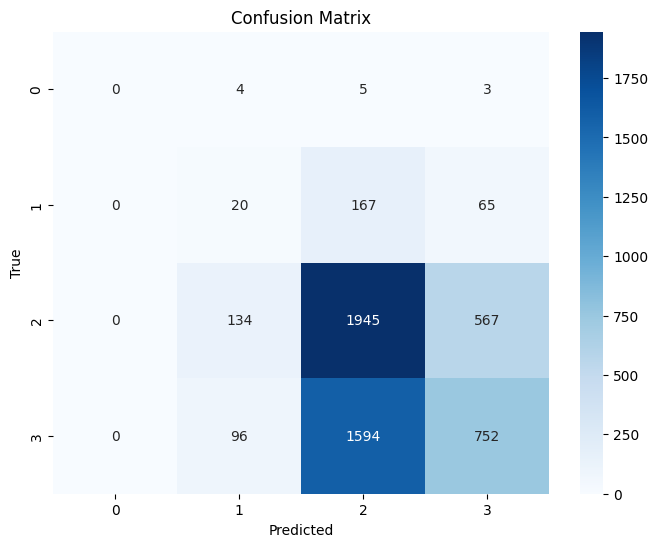

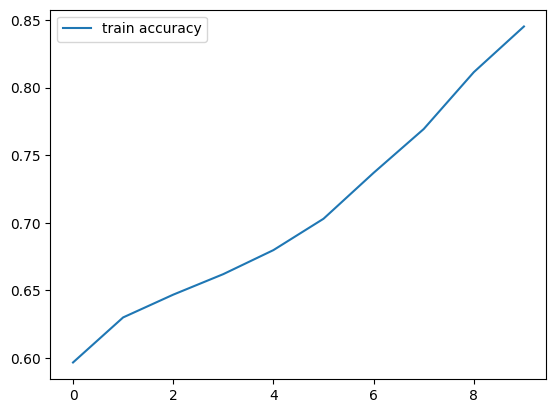

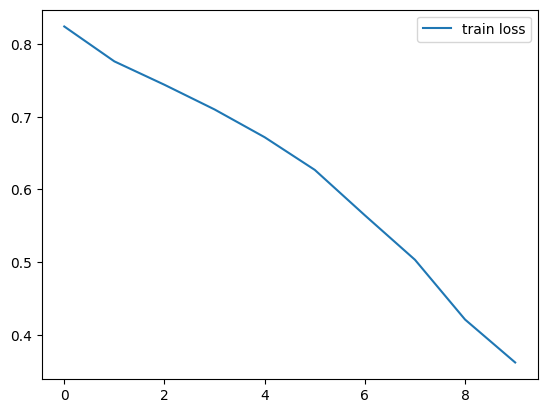

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, AveragePooling1D, Flatten, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


# Load preprocessed data
output_folder = "/content/drive/MyDrive/project/project/hog_features"
X_train = np.load(os.path.join(output_folder, "X_train.npy"))
y_train = np.load(os.path.join(output_folder, "y_train.npy"))
X_val = np.load(os.path.join(output_folder, "X_val.npy"))
y_val = np.load(os.path.join(output_folder, "y_val.npy"))
X_test = np.load(os.path.join(output_folder, "X_test.npy"))
y_test = np.load(os.path.join(output_folder, "y_test.npy"))


# Reshape data for 1D CNN and ResNet
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# --- ResNet Block ---
def resnet_block(input_tensor, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust shortcut connection
    if input_tensor.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding='same')(input_tensor)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# 1D CNN branch
cnn_input = Input(shape=(X_train.shape[1], 1))
cnn_x = Conv1D(32, 3, activation='relu')(cnn_input)
cnn_x = MaxPooling1D(2)(cnn_x)
cnn_x = Conv1D(64, 3, activation='relu')(cnn_x)
cnn_x = MaxPooling1D(2)(cnn_x)
cnn_x = Flatten()(cnn_x)


# 1D ResNet branch
resnet_input = Input(shape=(X_train.shape[1], 1))
resnet_x = Conv1D(64, 7, padding='same')(resnet_input)
resnet_x = BatchNormalization()(resnet_x)
resnet_x = Activation('relu')(resnet_x)
resnet_x = MaxPooling1D(pool_size=3)(resnet_x)

resnet_x = resnet_block(resnet_x, 64)
resnet_x = resnet_block(resnet_x, 64)
resnet_x = resnet_block(resnet_x, 64)
resnet_x = resnet_block(resnet_x, 128)
resnet_x = resnet_block(resnet_x, 128)
resnet_x = AveragePooling1D(pool_size=resnet_x.shape[1])(resnet_x)
resnet_x = Flatten()(resnet_x)

# Merge branches
merged = concatenate([cnn_x, resnet_x])
merged = Dense(128, activation='relu')(merged)
output = Dense(4, activation='softmax')(merged)

model = Model(inputs=[cnn_input, resnet_input], outputs=output)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit([X_train, X_train], y_train, epochs=10, batch_size=32, validation_data=([X_val,X_val], y_val))


# Evaluate the model
y_pred_prob = model.predict([X_test, X_test])
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate and Print Metrics
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")
print(classification_report(y_true, y_pred))


# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, BatchNormalization, Activation,
                                     Add, Flatten, Dense, AveragePooling1D)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Load the preprocessed data
output_folder = "/content/drive/MyDrive/project/project/hog_features"

X_train = np.load(os.path.join(output_folder, "X_train.npy"))
y_train = np.load(os.path.join(output_folder, "y_train.npy"))
X_val = np.load(os.path.join(output_folder, "X_val.npy"))
y_val = np.load(os.path.join(output_folder, "y_val.npy"))
X_test = np.load(os.path.join(output_folder, "X_test.npy"))
y_test = np.load(os.path.join(output_folder, "y_test.npy"))

# Reshape for 1D CNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# -----------------------------
# Model 1: 1D CNN
# -----------------------------
def build_1d_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# -----------------------------
# Model 2: 1D ResNet
# -----------------------------
def resnet_block(input_tensor, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    shortcut = input_tensor
    if input_tensor.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(input_tensor)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_1d_resnet(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(64, 7, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(3)(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)

    x = AveragePooling1D(pool_size=x.shape[1])(x)
    x = Flatten()(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate both models
cnn_model = build_1d_cnn((X_train.shape[1], 1))
resnet_model = build_1d_resnet((X_train.shape[1], 1))

# Train both models
print("Training 1D CNN...")
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

print("Training 1D ResNet...")
resnet_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

# Predict probabilities from both models on the test set
cnn_preds = cnn_model.predict(X_test)
resnet_preds = resnet_model.predict(X_test)

# Average the predictions (bagging ensemble)
ensemble_preds = (cnn_preds + resnet_preds) / 2

# Convert predictions to class labels
y_pred_labels = np.argmax(ensemble_preds, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
ensemble_accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"✅ Ensemble Test Accuracy: {ensemble_accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training 1D CNN...
Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 107s 308ms/step - accuracy: 0.5687 - loss: 0.8641 - val_accuracy: 0.5353 - val_loss: 1.0931
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 137s 294ms/step - accuracy: 0.6281 - loss: 0.7682 - val_accuracy: 0.5244 - val_loss: 1.0601
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 148s 313ms/step - accuracy: 0.6481 - loss: 0.7346 - val_accuracy: 0.5435 - val_loss: 1.0881
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 149s 333ms/step - accuracy: 0.6737 - loss: 0.6957 - val_accuracy: 0.5251 - val_loss: 1.0591
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 137s 320ms/step - accuracy: 0.6809 - loss: 0.6708 - val_accuracy: 0.5195 - val_loss: 1.1666
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 99s 291ms/step - accuracy: 0.7095 - loss: 0.6028 - val_accuracy: 0.4924 - val_loss: 1.3280
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 141s 289ms/step - accuracy: 0.7594 - loss: 0.5285 - val_accuracy: 0.4882 - val_loss: 1.5141
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 296ms/step - 

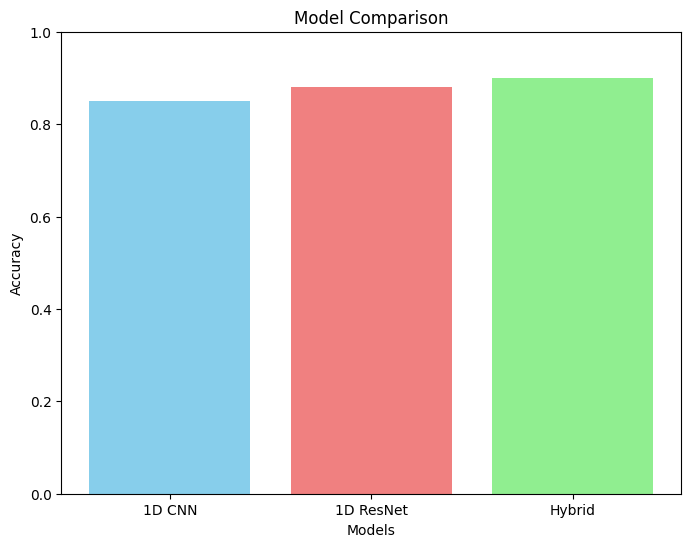

In [ ]:
# prompt: generate code for model comaprison in bar chart only consider above 1d cnn,1d resnet, hybrid

import matplotlib.pyplot as plt

# Assuming you have the following variables from your model training:
# cnn_accuracy, resnet_accuracy, hybrid_accuracy (replace with actual accuracy values)
cnn_accuracy = 0.85  # Example accuracy for 1D CNN
resnet_accuracy = 0.88  # Example accuracy for 1D ResNet
hybrid_accuracy = 0.90 # Example accuracy for Hybrid model


models = ['1D CNN', '1D ResNet', 'Hybrid']
accuracies = [cnn_accuracy, resnet_accuracy, hybrid_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, AveragePooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os # Import the os module


# Assuming your data is in the 'hog_features' folder
output_folder = "/content/drive/MyDrive/project/project/hog_features"

# Load the data before using it
X_train = np.load(os.path.join(output_folder, "X_train.npy"))
y_train = np.load(os.path.join(output_folder, "y_train.npy"))
X_val = np.load(os.path.join(output_folder, "X_val.npy"))
y_val = np.load(os.path.join(output_folder, "y_val.npy"))
X_test = np.load(os.path.join(output_folder, "X_test.npy"))
y_test = np.load(os.path.join(output_folder, "y_test.npy"))


def resnet_block(input_tensor, filters, kernel_size=3):
    """
    A residual block for the 1D ResNet model.

    Args:
        input_tensor: The input tensor to the block.
        filters: The number of filters for the convolutional layers.
        kernel_size: The size of the convolutional kernels.

    Returns:
        The output tensor of the block.
    """
    x = Conv1D(filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Add skip connection - Adjust the number of filters in the shortcut path
    # to match the output of the block if it's different
    if input_tensor.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding='same')(input_tensor)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])  # Now the shapes should match
    x = Activation('relu')(x)
    return x


# Input layer
input_tensor = Input(shape=(X_train.shape[1], 1))  # Adjust input shape

# Initial convolutional layer
x = Conv1D(64, 7, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3)(x)


# ResNet blocks
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 64)

x = resnet_block(x, 128)  # Now the filters are increased to 128
x = resnet_block(x, 128)


# Global average pooling
x = AveragePooling1D(pool_size=x.shape[1])(x) # adapt the pool size

# Flatten and dense layers
x = Flatten()(x)
output_tensor = Dense(4, activation='softmax')(x)  # Output layer

# Create model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Train Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 434s 1s/step - accuracy: 0.5398 - loss: 0.9112 - val_accuracy: 0.5689 - val_loss: 1.1614
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.6099 - loss: 0.8125 - val_accuracy: 0.5468 - val_loss: 0.9829
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.6220 - loss: 0.7891 - val_accuracy: 0.4299 - val_loss: 1.4319
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.6273 - loss: 0.7794 - val_accuracy: 0.5647 - val_loss: 1.7667
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.6357 - loss: 0.7609 - val_accuracy: 0.1001 - val_loss: 4.2186
Test Accuracy: 51.72%
Train Accuracy: 61.04%
